这是李宏毅[GAN课程](https://www.youtube.com/watch?v=DQNNMiAP5lw)的学习笔记

In [7]:
import torch.nn as nn
import torch
from torch import optim
from torch.autograd import Variable
import torchvision

![image.png](https://i-blog.csdnimg.cn/blog_migrate/fcf7cf87abbc78b0e4bdd28de26c8dd4.png#pic_center)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:#find() 返回字符串第一次出现的索引，如果没有匹配项则返回-1
        m.weight.data.normal_(0.0, 0.02)#归一化
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class G(nn.Module):
    def __init__(self,in_dims=1024,out_dim=512):
        # in_dims指的是输出的随机向量的维度 ; out_dims指的是输出图像的尺寸
        super(G,self).__init__()
        self.model=nn.Sequential()

        self.fn1=nn.Sequential(nn.Linear(in_dims,out_dim*1024),
                               nn.BatchNorm1d(out_dim*1024),
                               nn.ReLU()) #经过第一层线性层之后记得reshape为64*64*1024的形状
        
        self.arcconv1=nn.ConvTranspose2d(in_channels=2048,out_channels=1024,kernel_size=5,stride=4,padding=2,output_padding=3)
        self.rl1=nn.ReLU()
        self.arcconv2=nn.ConvTranspose2d(in_channels=1024,out_channels=256,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.rl2=nn.ReLU()
        self.arcconv3=nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.rl3=nn.ReLU()
        self.arcconv4=nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.rl4=nn.Tanh()

        self.fn2=(self.arcconv1,self.rl1,self.arcconv2,self.rl2,self.arcconv3,self.rl3,self.arcconv4,self.rl4)

        self.apply(weights_init)
        

    def forward(self,x):
        z=self.f1(x)
        z=z.view(-1,1024,64,64)
        z=self.fn2(z)
        return z

In [12]:
class D(nn.Module):
    def __init__(self,in_dims=3,dims=64):
        # 输入的数据格式应该是  N*3*512*512
        super(D, self).__init__()
        
        self.model = nn.Sequential()

        def conv_binary_2d(in_dim,out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim,out_dim,5,2,2),
                nn.BatchNorm2d(out_dim),nn.LeakyReLU(0.15)
            )
        self.model.append(nn.Conv2d(in_dims, dims, 10, 8, 1))
        self.model.append(nn.LeakyReLU(0.1))
        self.model.append(conv_binary_2d(dims,2*dims))
        self.model.append(conv_binary_2d(2*dims,4*dims))
        self.model.append(conv_binary_2d(4*dims,8*dims))
        self.model.append(conv_binary_2d(8*dims,16*dims))
        self.model.append(nn.Conv2d(16*dims,1,4))
        self.model.append(nn.Sigmoid())
        self.apply(weights_init)
    
    def forward(self,x):
        # 返回是一个batch-size的一维数组
        z=self.model(x)
        z=z.view(-1)
        return z

In [13]:
# 开始训练！
import os

batch_size=32
feature_dim=128 #设置特征向量的大小

lr=5e-5
n_epoch=100

workspace_dir = '.'
save_dir=os.path.join(workspace_dir,'logs')
os.makedirs(save_dir,exist_ok=True)

G_model = G(in_dims=feature_dim).cuda()
D_model = D(3).cuda()
G_model.train()
D_model.train()


D(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(8, 8), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.15)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.15)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.15)
    )
    (5): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(1024, eps=1e-05,

In [ ]:
criterion=nn.BCELoss()

# optimizer
opt_D = torch.optim.Adam(D_model.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G_model.parameters(), lr=lr, betas=(0.5, 0.999))

import random
import numpy as np
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x254F31AEC40>
tensor([[[0.9882, 0.9843, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9843, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9843, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9765, 1.0000, 1.0000,  ..., 0.9490, 0.9255, 0.9098],
         [0.9961, 1.0000, 0.9922,  ..., 0.9333, 0.9098, 0.8902],
         [1.0000, 0.9882, 0.9647,  ..., 0.9216, 0.8980, 0.8784]],

        [[0.8392, 0.8392, 0.8431,  ..., 0.9608, 0.9608, 0.9608],
         [0.8392, 0.8392, 0.8431,  ..., 0.9608, 0.9608, 0.9608],
         [0.8392, 0.8392, 0.8431,  ..., 0.9569, 0.9569, 0.9569],
         ...,
         [0.8784, 0.9137, 0.9176,  ..., 0.9059, 0.8824, 0.8667],
         [0.9020, 0.9098, 0.9020,  ..., 0.8902, 0.8667, 0.8471],
         [0.9333, 0.9020, 0.8745,  ..., 0.8784, 0.8549, 0.8353]],

        [[0.8039, 0.8039, 0.7961,  ..., 0.9765, 0.9765, 0.9765],
         [0.8039, 0.8039, 0.7961,  ..., 0.

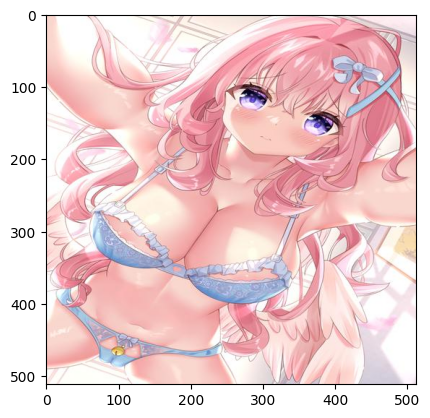

In [47]:
from torch.utils.data import Dataset, DataLoader
import glob
import os
import torchvision.transforms as transforms
from PIL import Image

class GAN_dataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        :param image_dir: 存储图像的目录
        :param transform: 可选的转换操作
        """
        
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        print(image)
        if self.transform:
            image = self.transform(image)
        # transform = transforms.ToTensor()
        # image=transform(image)

        return image

#这里可以加载自己想加载的数据
def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # resize the image to (64, 64)
    # linearly map [0, 1] to [-1, 1]线性转换

    #transform这个我前面的作业解释的很清楚，
    #这就不再重复解释了，看过一遍就会觉得很简单
    t = transforms.ToTensor()
    dataset = GAN_dataset(root, transform=t)
    return dataset

dataset = get_dataset(os.path.join(workspace_dir, 'raw_GAN'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

import matplotlib.pyplot as plt
print(dataset[10])
plt.imshow(torch.Tensor(dataset[10]).permute(1, 2, 0))